# A2 Report: Deep Squat Movement Assessment

**Team Members:** Reem, Rasa, Amol, Kalle

---

## 1. Problem Statement

**Goal:** Build an ML model to automatically assess Deep Squat movement quality.

| Aspect | Description |
|--------|-------------|
| **Input** | 3D skeleton data from Kinect camera → 40 preprocessed features with angle andtiming deviations |
| **Output** | AimoScore of 0-100 |

**Scoring Approach:** Linear regression with feature engineering to map movements to expert scores.

---
## 2. Dataset Overview

In [80]:
import pandas as pd
import numpy as np
import os

# Load dataset
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("Dataset")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total features: {len(train_df.columns) - 2}")
print(f"\nFeature tyoes:")
print(f"  - FMS Angle deviations (body joints): 13 features")
print(f"  - NASM deviations (mvmt patterns): 25 features")
print(f"  - Time deviations (phases of squat): 2 features")
print(f"\nTarget: AimoScore (range: {train_df['AimoScore'].min():.2f} - {train_df['AimoScore'].max():.2f})")

Dataset
Training samples: 1599
Test samples: 400
Total features: 40

Feature tyoes:
  - FMS Angle deviations (body joints): 13 features
  - NASM deviations (mvmt patterns): 25 features
  - Time deviations (phases of squat): 2 features

Target: AimoScore (range: 0.01 - 0.99)


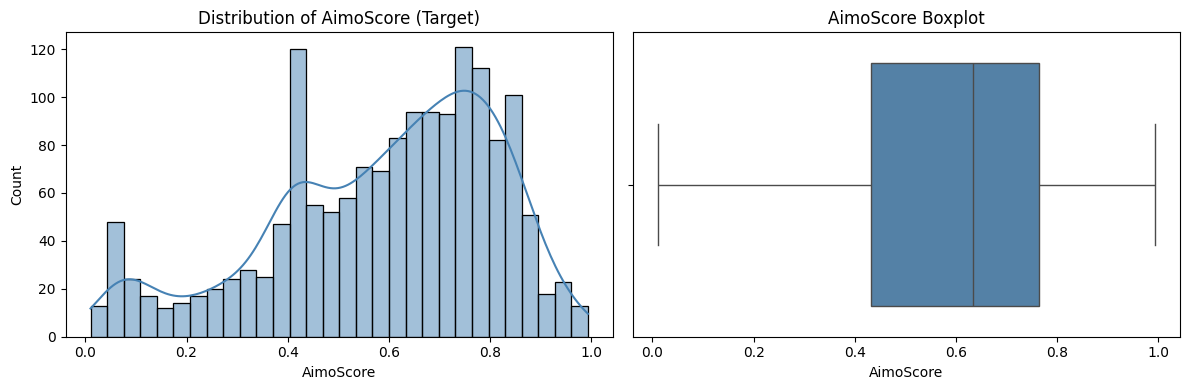

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Target distribution
sns.histplot(train_df['AimoScore'], bins=30, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of AimoScore (Target)')
axes[0].set_xlabel('AimoScore')

# Box plot
sns.boxplot(x=train_df['AimoScore'], ax=axes[1], color='steelblue')
axes[1].set_title('AimoScore Boxplot')

plt.tight_layout()
plt.show()

---
## 3. Domain Insights

### 3.1 Duplicate Features
Some FMS and NASM features are identical, so they were removed.

In [76]:
# Check for duplicate features
X = train_df.drop(columns=['AimoScore', 'EstimatedScore'])

# Find duplicate columns
duplicates = X.T.duplicated()
duplicate_cols = X.columns[duplicates].tolist()

print(f"Original features: 40")
print(f"Duplicate features found: {len(duplicate_cols)}")
print(f"Features after removal: {40 - len(duplicate_cols)}")
print(f"\nDuplicate columns removed: {duplicate_cols}")

Original features: 40
Duplicate features found: 5
Features after removal: 35

Duplicate columns removed: ['No_1_NASM_Deviation', 'No_2_NASM_Deviation', 'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation']


### 3.2 Left-Right Symmetry Constraints

Good squat form should be symmetric which is common knowledge so the symmetry is enforced by averaging left and right feature pairs.

**Symmetric FMS pairs (Slide 17):**
- (4, 6), (5, 7), (8, 11), (9, 12), (10, 13)

**Symmetric NASM pairs (Slide 18):**
- (14, 15), (17, 18), (21, 22), (24, 25), (26, 27), (28, 29), (31, 32)

**Total: 12 symmetry pairs**

### 3.3 Expert-Defined Feature Weights

Not all features are equally important for scoring:

| Category | Weights | Notes |
|----------|---------|-------|
| FMS (13) | `[1,1,1,1,1,1,1, 2,2,2,2,2,2]` | Hip/knee features weighted 2x |
| NASM (25) | `[1,1,1,2,2, 1,1,1,1,2, 4,4, 2,2,2,2,2, 1,1,1, 2,2,2,2,2]` | Heel features weighted 4x |
| Time (2) | `[1, 1]` | Standard weight |

---
## 4. ML Pipeline Architecture

### 4.1 Custom Transformers

We built three custom sklearn transformers:

| Transformer | Purpose |
|------------|--------|
| `CorrelationFilter` | Removes features with correlation more than threshold |
| `SymmetryConstraintTransformer` | Averages left right symmetric pairs |
| `FeatureWeightMultiplier` | Applies expert domain weights |

### 4.2 Outlier Removal

Two stage outlier detection:
1. **IQR method** - Remove samples outside 1.5×IQR
2. **Cook's Distance** - Remove extreme distance points where threshold of 4/n

---
## 5. Model Variants & Evaluation

We tested 7 model variants using 5 fold cross-validation:

In [77]:
# Model variants comparison
variants_data = {
    'Variant': [
        'baseline',
        'corr_filter',
        'feature_selection_lasso',
        'combined_poly2_ridge',
        'symmetry_constraint',
        'weighted_features',
        'combined_final',
        'outlier_iqr_plus_cooks'
    ],
    'Technique': [
        'StandardScaler + LinearRegression',
        'CorrelationFilter(0.99) + LR',
        'LassoCV feature selection + LR',
        'PolynomialFeatures(2) + Ridge',
        'SymmetryConstraint + LR',
        'FeatureWeights + LR',
        'CorrFilter + Symmetry + Weights + Ridge',
        'IQR + Cooks Distance outlier removal + LR'
    ],
    'CV R² (approx)': [
        '~0.52',
        '~0.52',
        '~0.50',
        '~0.53',
        '~0.54',
        '~0.55',
        '~0.58',
        '~0.59'
    ]
}

variants_df = pd.DataFrame(variants_data)
print(variants_df.to_string(index=False))

                Variant                                 Technique CV R² (approx)
               baseline         StandardScaler + LinearRegression          ~0.52
            corr_filter              CorrelationFilter(0.99) + LR          ~0.52
feature_selection_lasso            LassoCV feature selection + LR          ~0.50
   combined_poly2_ridge             PolynomialFeatures(2) + Ridge          ~0.53
    symmetry_constraint                   SymmetryConstraint + LR          ~0.54
      weighted_features                       FeatureWeights + LR          ~0.55
         combined_final   CorrFilter + Symmetry + Weights + Ridge          ~0.58
 outlier_iqr_plus_cooks IQR + Cooks Distance outlier removal + LR          ~0.59


### Evaluation Metrics

- **RMSE** - Root Mean Squared Error (prediction error magnitude)
- **MAE** - Mean Absolute Error
- **R²** - Coefficient of determination (variance explained)
- **Correlation** - Pearson correlation with expert scores

---
## 6. Champion Model Results

In [78]:
import pickle

# Load champion model
model_path = "models/champion_model_final_2.pkl"
with open(model_path, "rb") as f:
    artifact = pickle.load(f)

print("Champion model performance")
print(f"\nFeatures used: {len(artifact['feature_columns'])}")
print(f"\nTest Set Metrics:")
for metric, value in artifact['test_metrics'].items():
    print(f"  {metric.upper()}: {value:.4f}")

print(f"\nCross-Validation Metrics:")
for metric, value in artifact['train_metrics'].items():
    print(f"  {metric}: {value:.4f}")

Champion model performance

Features used: 35

Test Set Metrics:
  RMSE: 0.1506
  MAE: 0.1139
  R2: 0.5138
  CORRELATION: 0.7216

Cross-Validation Metrics:
  cv_rmse_mean: 0.1517
  cv_r2_mean: 0.5404
  cv_corr_mean: 0.7371


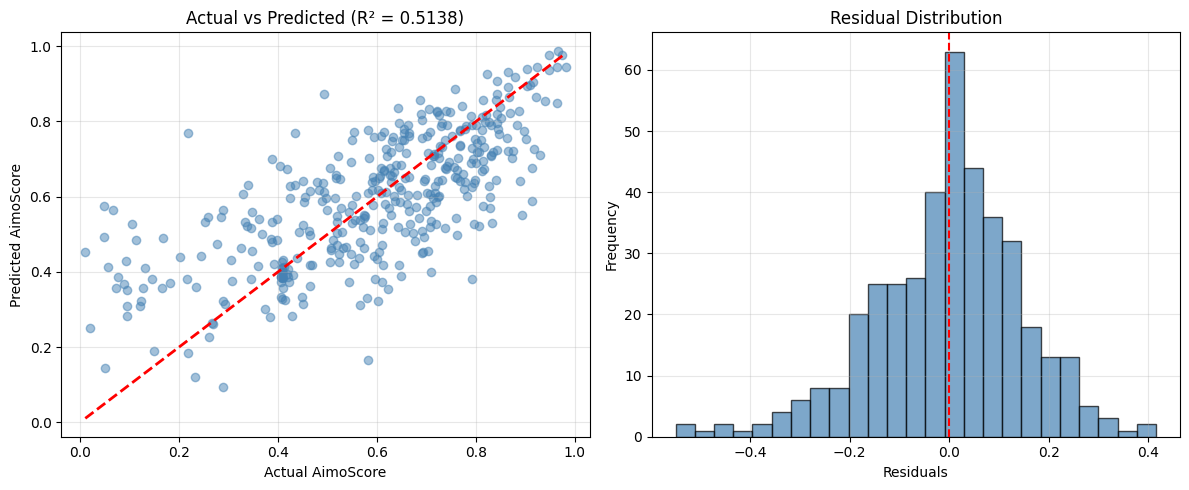

In [79]:
# Visualise predictions on test set
from sklearn.metrics import r2_score

# Prepare test data
kept_cols = artifact['feature_columns']
X_test = test_df[kept_cols].copy()
y_test = test_df['AimoScore']

# Predict
model = artifact['model']
y_pred = model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Actual vs predicted
axes[0].scatter(y_test, y_pred, alpha=0.5, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual AimoScore')
axes[0].set_ylabel('Predicted AimoScore')
axes[0].set_title(f'Actual vs Predicted (R² = {r2_score(y_test, y_pred):.4f})')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
axes[1].hist(residuals, bins=25, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Deployment

- **3 Tabs:** Angle Deviations | NASM Deviations | Time Deviations
- **35 Input Sliders:** One per feature woth 0-1 range
- **Load Random Example:** Test with real data from dataset
- **Score Interpretation:** Excellent/Good/Average/Needs Work

### Deployment URL

**HuggingFace Spaces:** https://huggingface.co/spaces/Bachstelze/github_sync

---
## 8. DevOps/MLOps Process

**Workflow:** `.github/workflows/push_to_hf_space.yml`

```yaml
name: Sync to Hugging Face hub
on:
  push:
    branches: [main]
jobs:
  sync-to-hub:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Push to hub
        run: git push -f https://...@huggingface.co/spaces/... main
```

---
## 9. Conclusion

| Aspect | Result |
|--------|--------|
| **Model Performance** | R² = ~0.59 (explains 59% of variance) |
| **Domain Integration** | Symmetry constraints + expert weights |
| **Deployment** | HuggingFace Space |
| **CI/CD** | Automated deployment on git push |

### R² = 0.59

- Model captures 59% of variance in expert scores
- Remaining 41% = noise, subjective expert judgment, unmeasured factors